In [1]:
import torch
import torch.nn as nn
from torch.utils import data
import json
import numpy as np
import random
from PIL import Image
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import pandas as pd
from torch.cuda.amp import autocast, GradScaler
import os
import sys
import random
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import pandas as pd

import src.network as network
from src.metrics import StreamSegMetrics
from datasets.kitti_360 import KittiDatasetLoader
from datasets.cityscapes_v1 import CityscapesDatasetLoader



In [2]:

# Defining the model paths
model_name = "deeplabv3plus_resnet101"
old_model_path = 'checkpoints/best_deeplabv3plus_resnet101_cityscapes_os16.pth'
new_model_path = 'checkpoints/ranked_2k_class_SL_full_KD_pixel.pth'


In [3]:
# Load model
def load_model(checkpoint_path, model_name='deeplabv3plus_resnet101', num_classes=19, output_stride=16):
    model = network.modeling.__dict__[model_name](num_classes=num_classes, output_stride=output_stride)
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint["model_state"])
    model = nn.DataParallel(model)
    model.to(device)
    return model


In [4]:
# Load data
def load_data(json_file, dataset_name, num_test=400):
    if dataset_name == 'cityscapes':
        dataset_loader = CityscapesDatasetLoader()
    elif dataset_name == 'kitti_360':
        dataset_loader = KittiDatasetLoader()
    else:
        raise ValueError(f"Invalid dataset: {dataset_name}")

    with open(json_file, 'r') as file:
        json_data = json.load(file)

    val_image_paths = [item.get('image') for item in json_data if item.get('image_exists')]
    val_ground_truth_paths = [item.get('ground_truth') for item in json_data if item.get('ground_truth_exists')]

    if len(val_image_paths) > num_test:
        sampled_indices = np.random.choice(len(val_image_paths), num_test, replace=False)
        val_image_paths = [val_image_paths[i] for i in sampled_indices]
        val_ground_truth_paths = [val_ground_truth_paths[i] for i in sampled_indices]
        print(f"Sampled {num_test} images from the dataset")

    val_dst = dataset_loader.get_datasets(val_image_paths, val_ground_truth_paths)
    val_loader = data.DataLoader(val_dst, batch_size=4, shuffle=True, num_workers=4, pin_memory=True)
    return val_loader, val_image_paths, val_ground_truth_paths


In [5]:
# Validate model
def validate(model, loader, device, metrics):
    metrics.reset()
    scaler = GradScaler()

    with torch.no_grad():
        for i, (images, labels) in tqdm(enumerate(loader), total=len(loader)):
            images = images.to(device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.long)
            
            with autocast():
                outputs = model(images)
            
            preds = outputs.detach().max(dim=1)[1].cpu().numpy()
            targets = labels.cpu().numpy()
            metrics.update(targets, preds)

            # Clear cache to free memory
            del images, labels, outputs
            torch.cuda.empty_cache()
    
    return metrics.get_results()


In [6]:
# Calculate additional metrics
def calculate_additional_metrics(metrics, num_classes):
    precision, recall, f1, _ = precision_recall_fscore_support(metrics.all_targets, metrics.all_preds, average='weighted')
    cm = confusion_matrix(metrics.all_targets, metrics.all_preds, labels=range(num_classes))
    return {
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Confusion Matrix': cm
    }


In [7]:
def plot_confusion_matrix(cm, class_names, title=None, normalize=True):
    plt.figure(figsize=(12, 10))
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'
    
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    if title:
        plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
metrics = StreamSegMetrics(19)


Using device: cuda


In [9]:
# Load models
baseline_model = load_model(old_model_path)
finetuned_model = load_model(new_model_path)


In [10]:
# Load data
datasets = [
    ('cityscapes', 'tests/cityscapes_val_set.json'),
    ('kitti_360', 'tests/kitti-360_val_set_v3.json')
]

class_names = [
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light', 'traffic sign',
    'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'train',
    'motorcycle', 'bicycle'
]



Analyzing CITYSCAPES dataset:


100%|██████████| 125/125 [02:15<00:00,  1.09s/it]


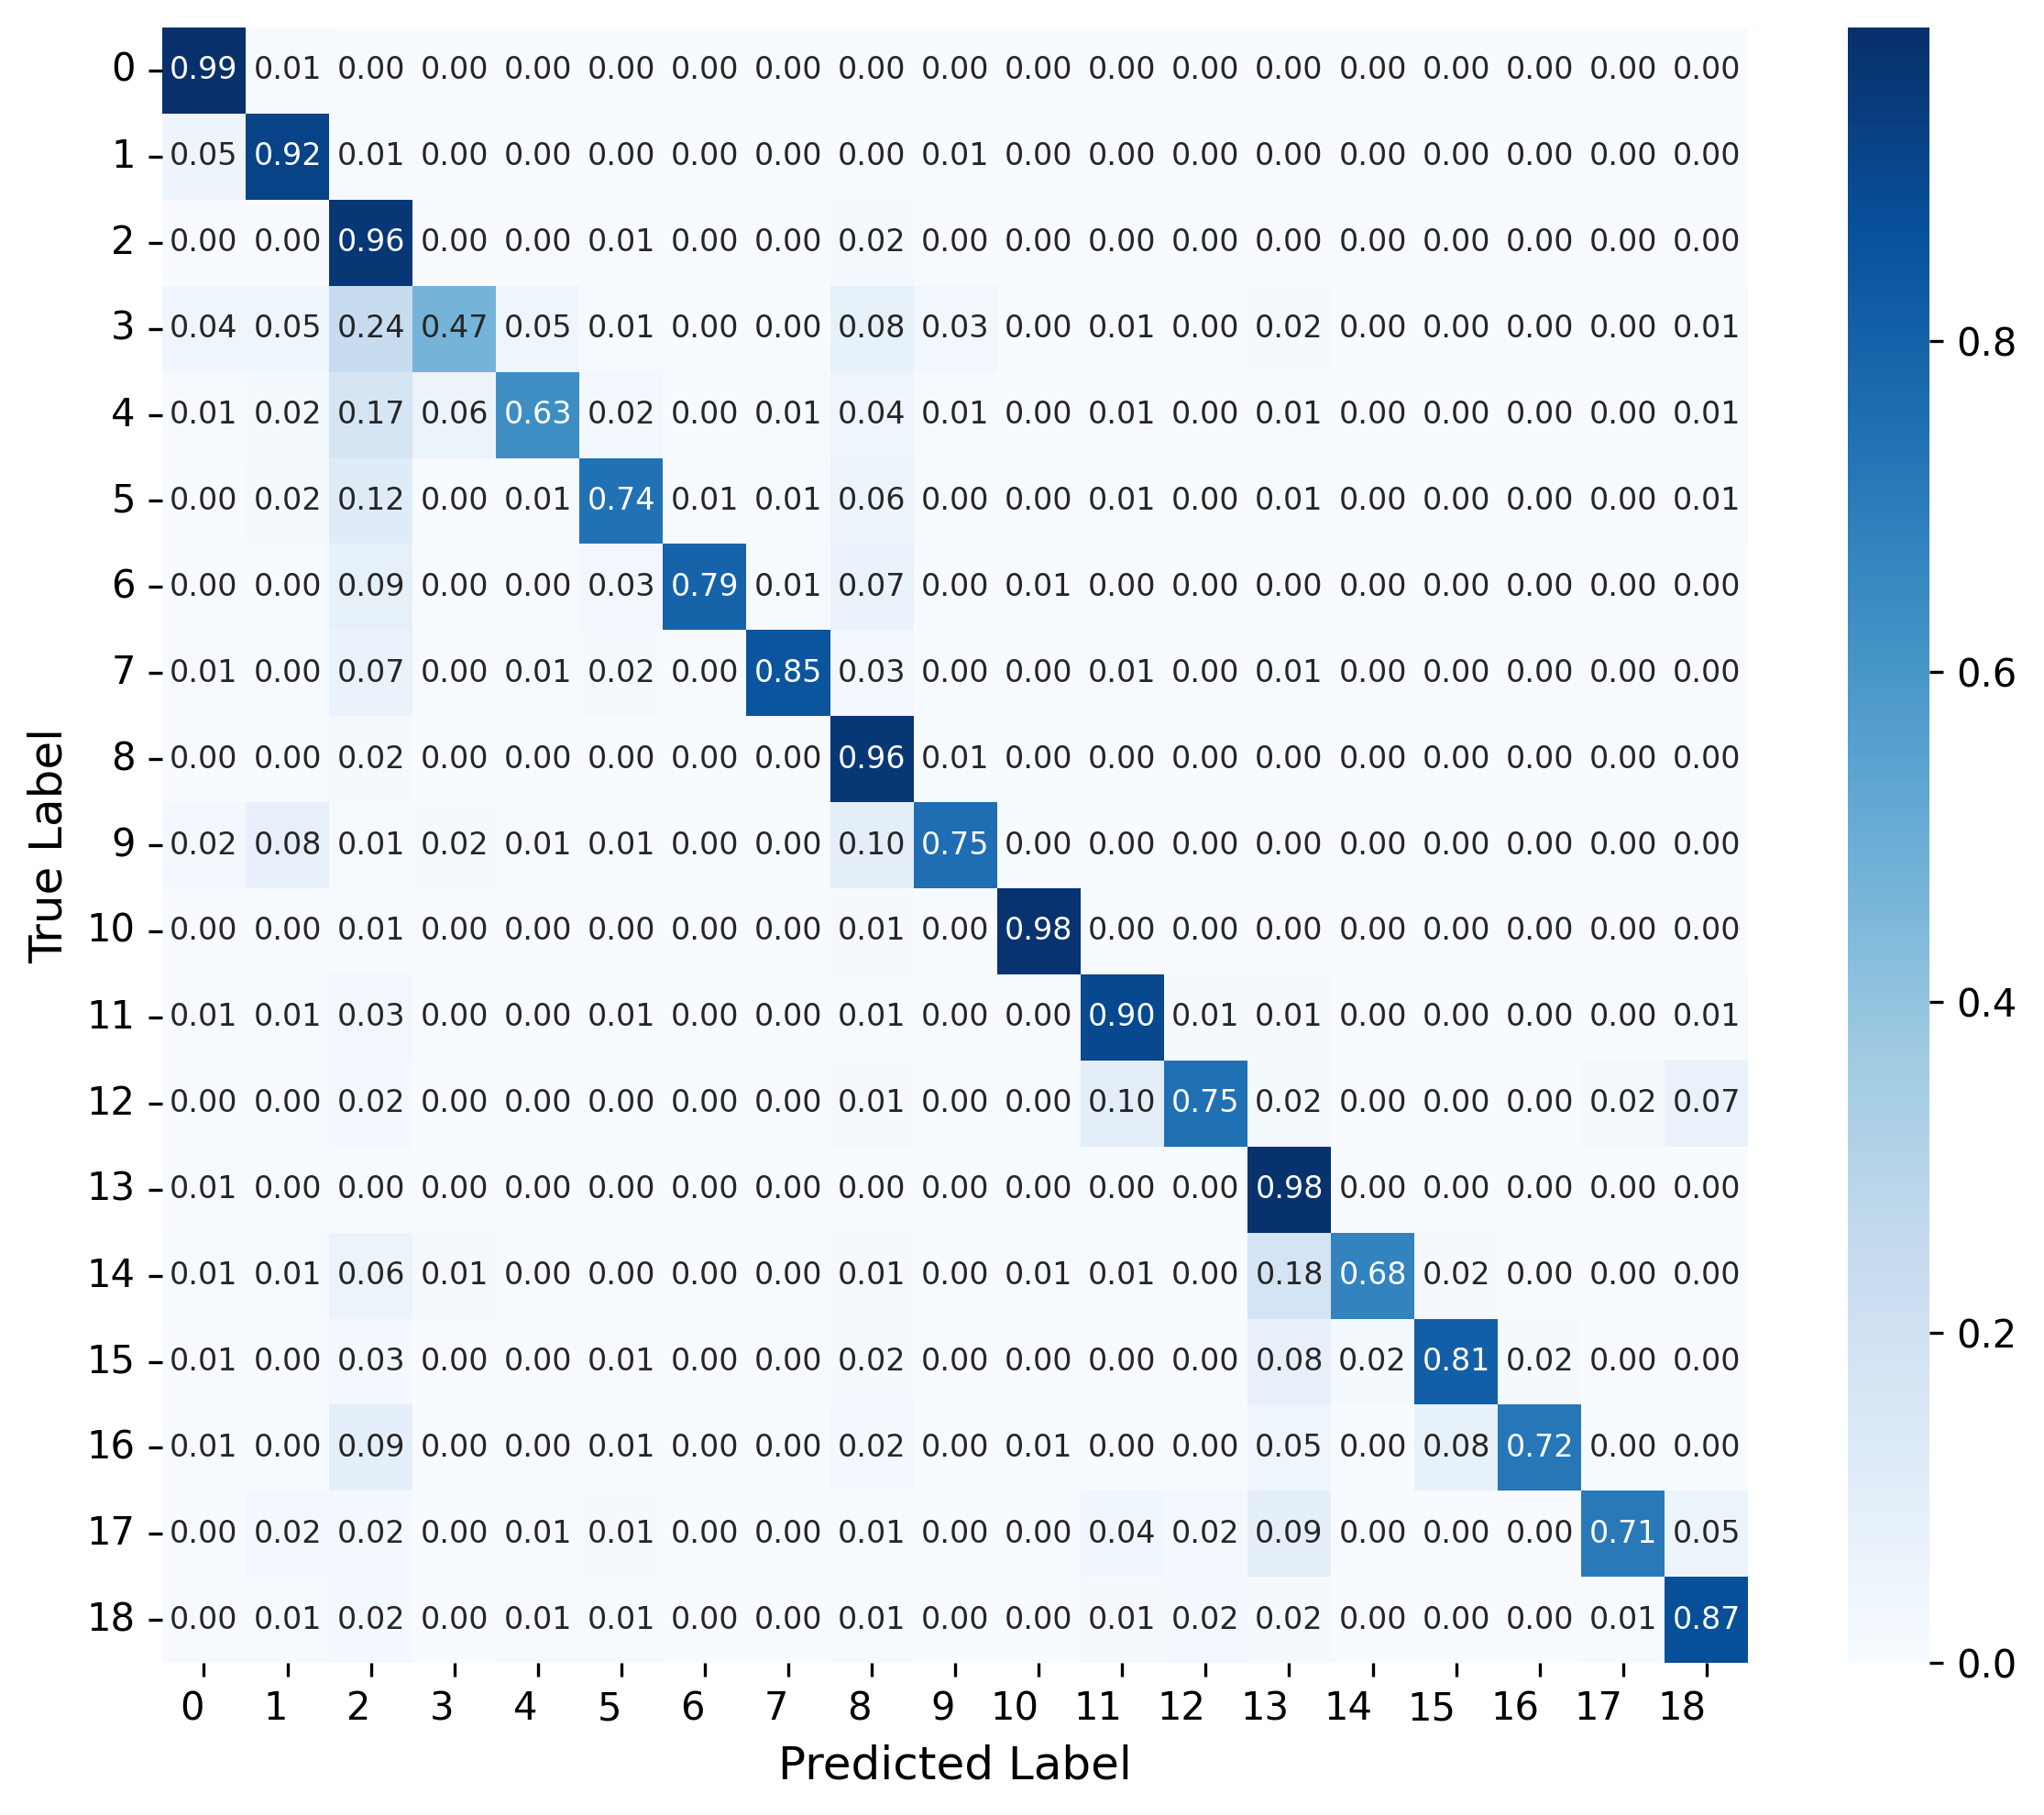

100%|██████████| 125/125 [02:04<00:00,  1.00it/s]


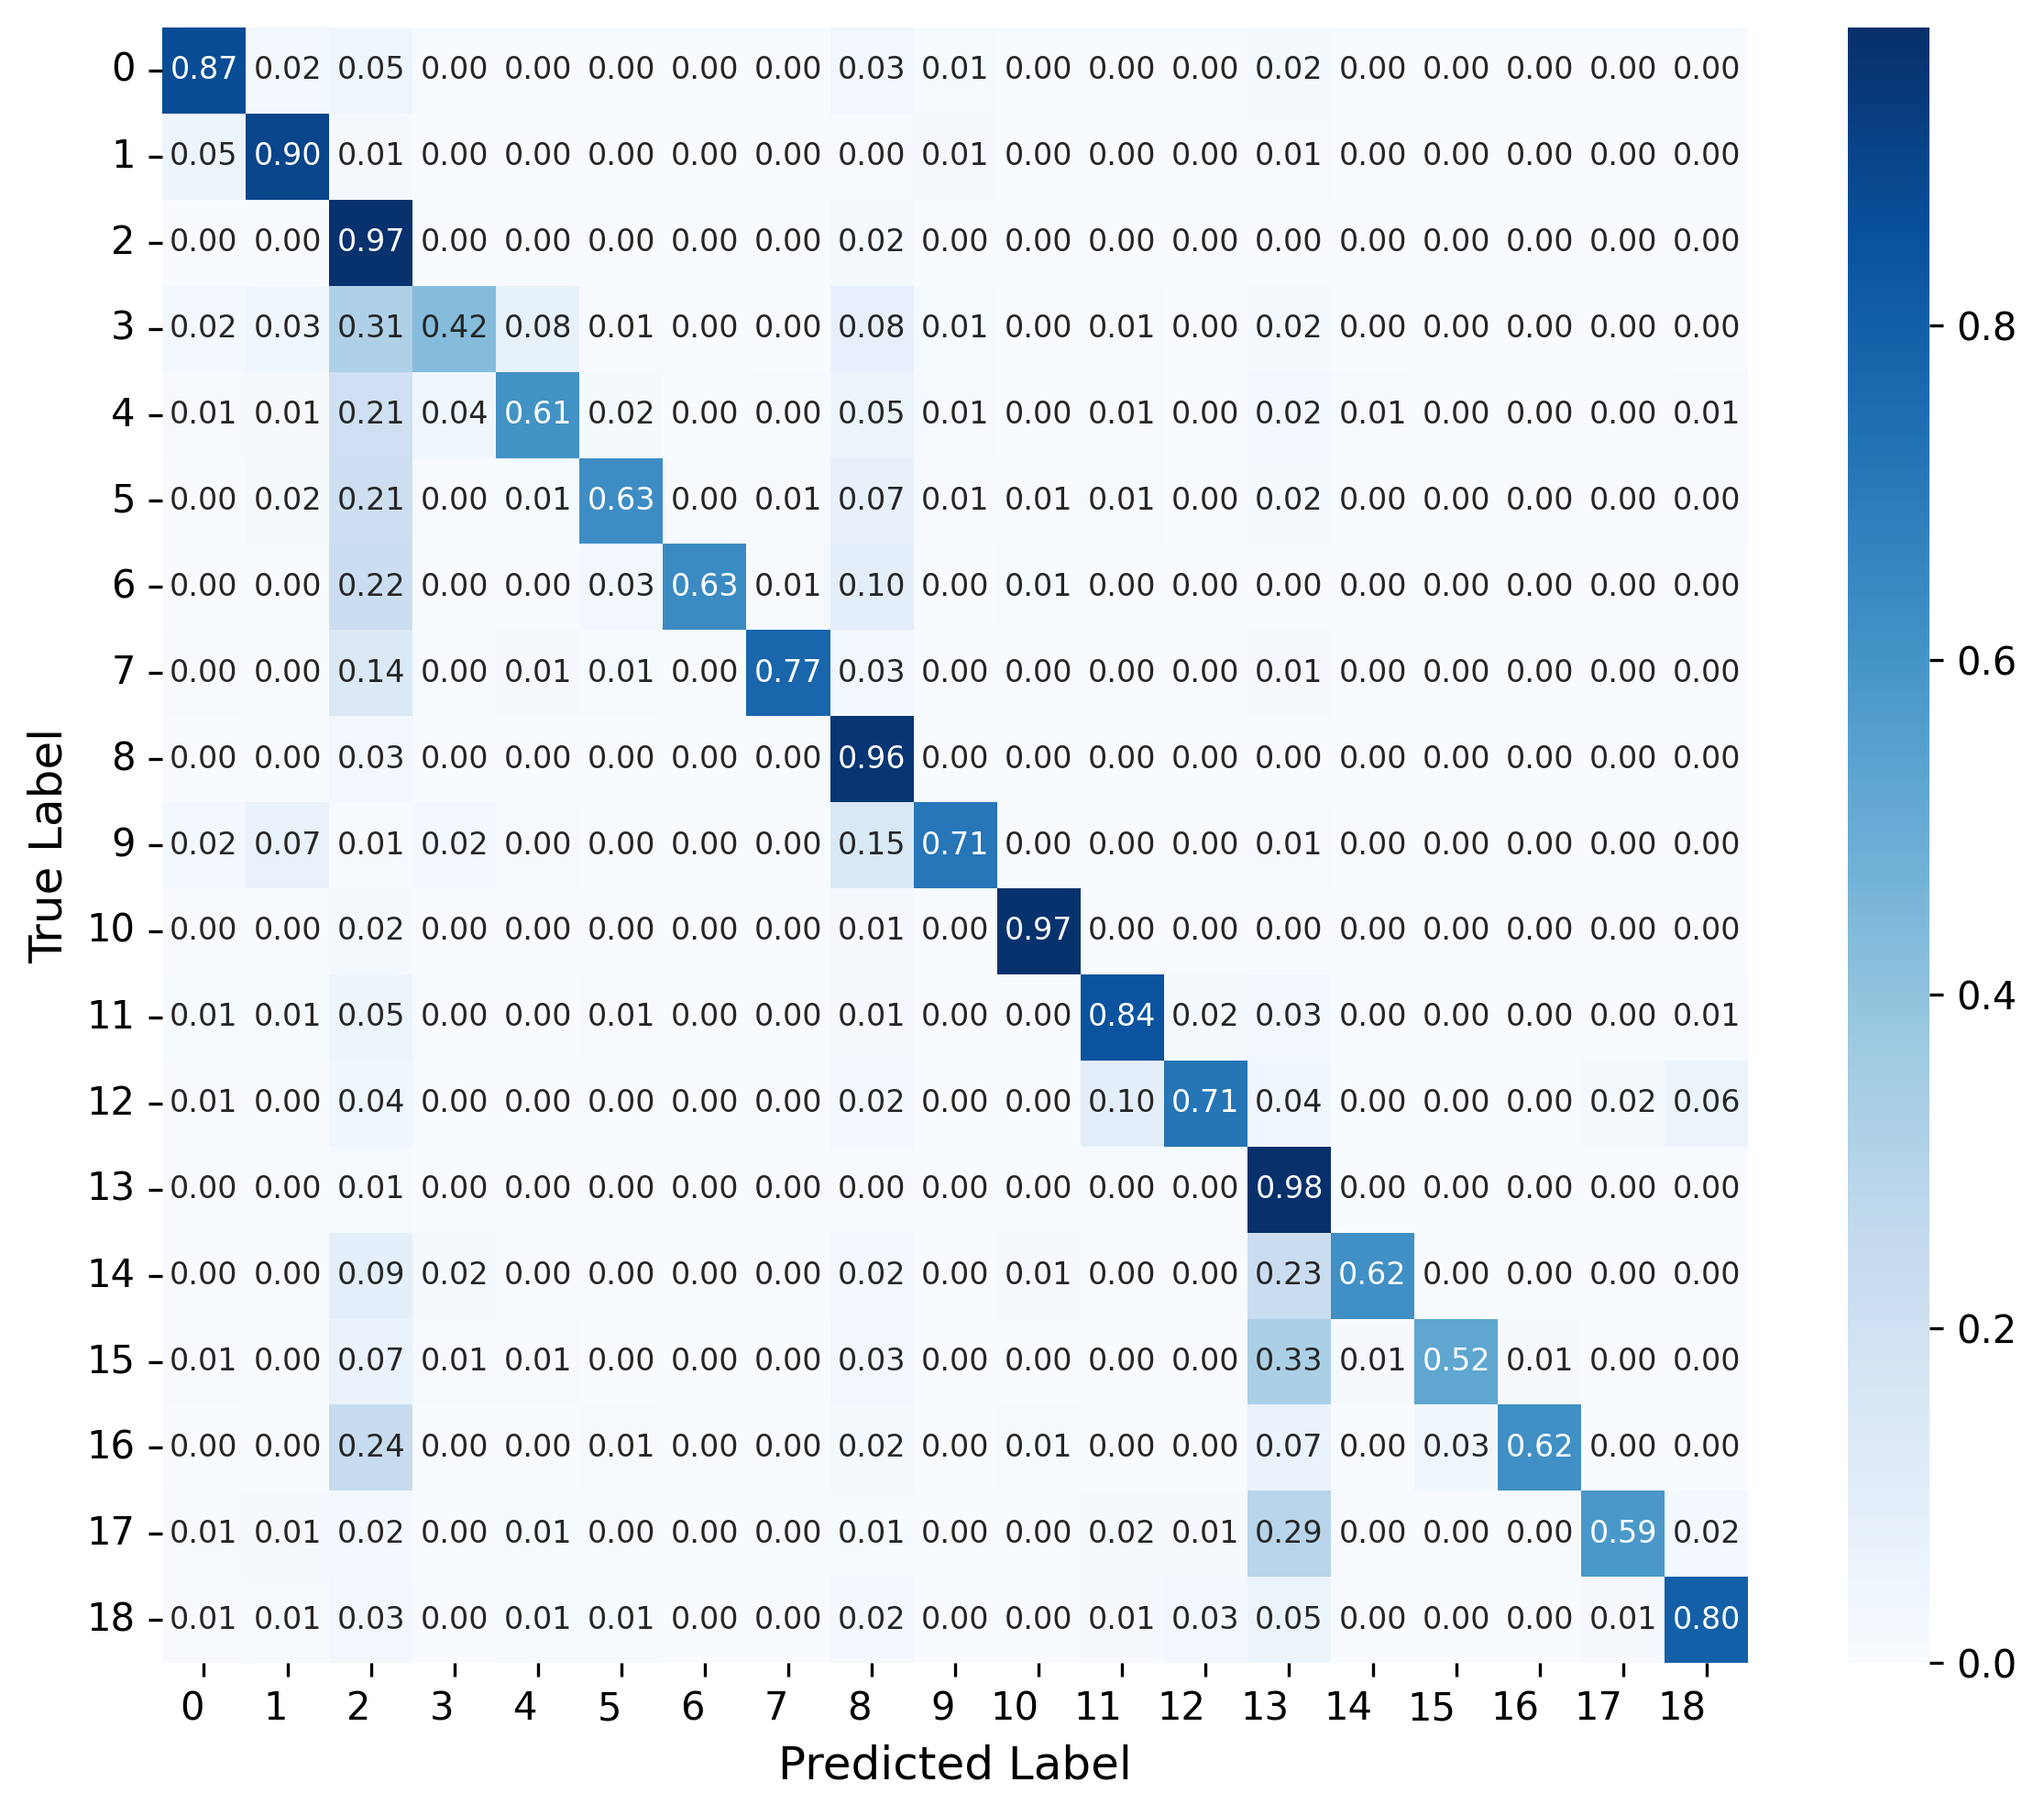


Analyzing KITTI_360 dataset:
Sampled 2000 images from the dataset


100%|██████████| 500/500 [02:52<00:00,  2.90it/s]
d:\DL_Lab24\Project\DeeplabV3_Cityscapes\src\metrics\stream_metrics.py:69: RuntimeWarning: invalid value encountered in divide
  acc_cls = np.diag(hist) / hist.sum(axis=1)
d:\DL_Lab24\Project\DeeplabV3_Cityscapes\src\metrics\stream_metrics.py:115: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


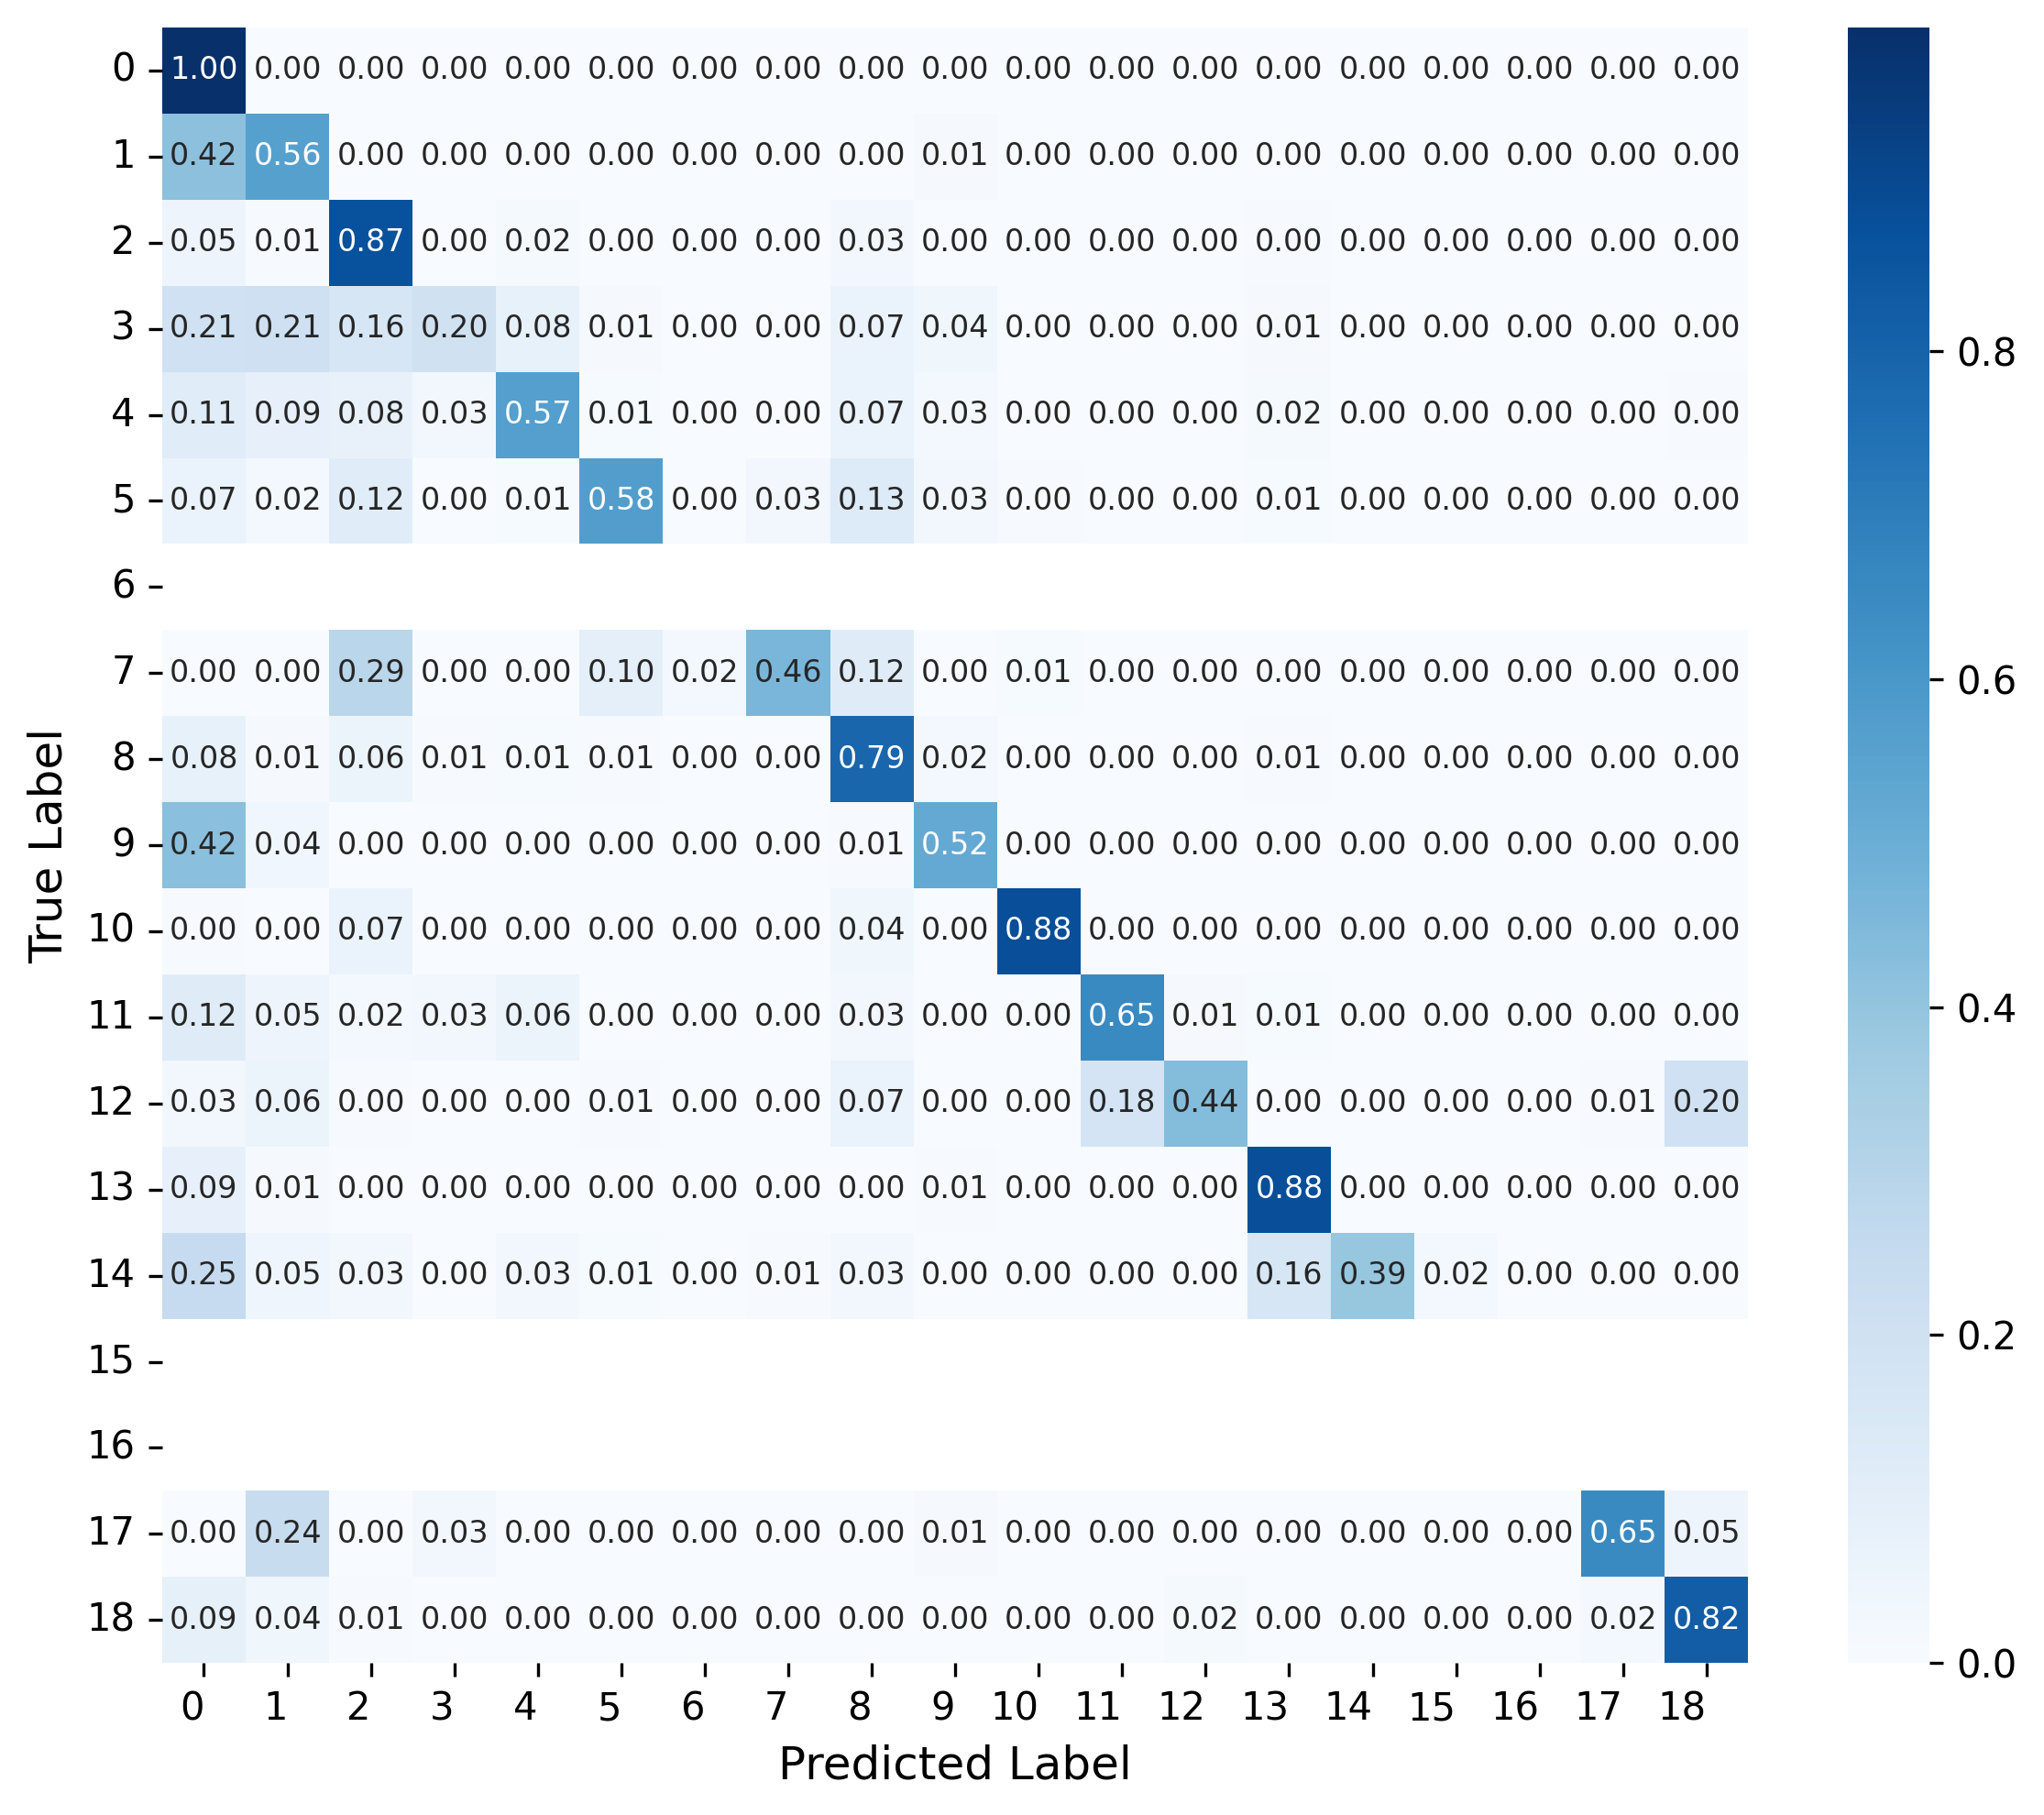

100%|██████████| 500/500 [02:29<00:00,  3.35it/s]
d:\DL_Lab24\Project\DeeplabV3_Cityscapes\src\metrics\stream_metrics.py:69: RuntimeWarning: invalid value encountered in divide
  acc_cls = np.diag(hist) / hist.sum(axis=1)
d:\DL_Lab24\Project\DeeplabV3_Cityscapes\src\metrics\stream_metrics.py:115: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


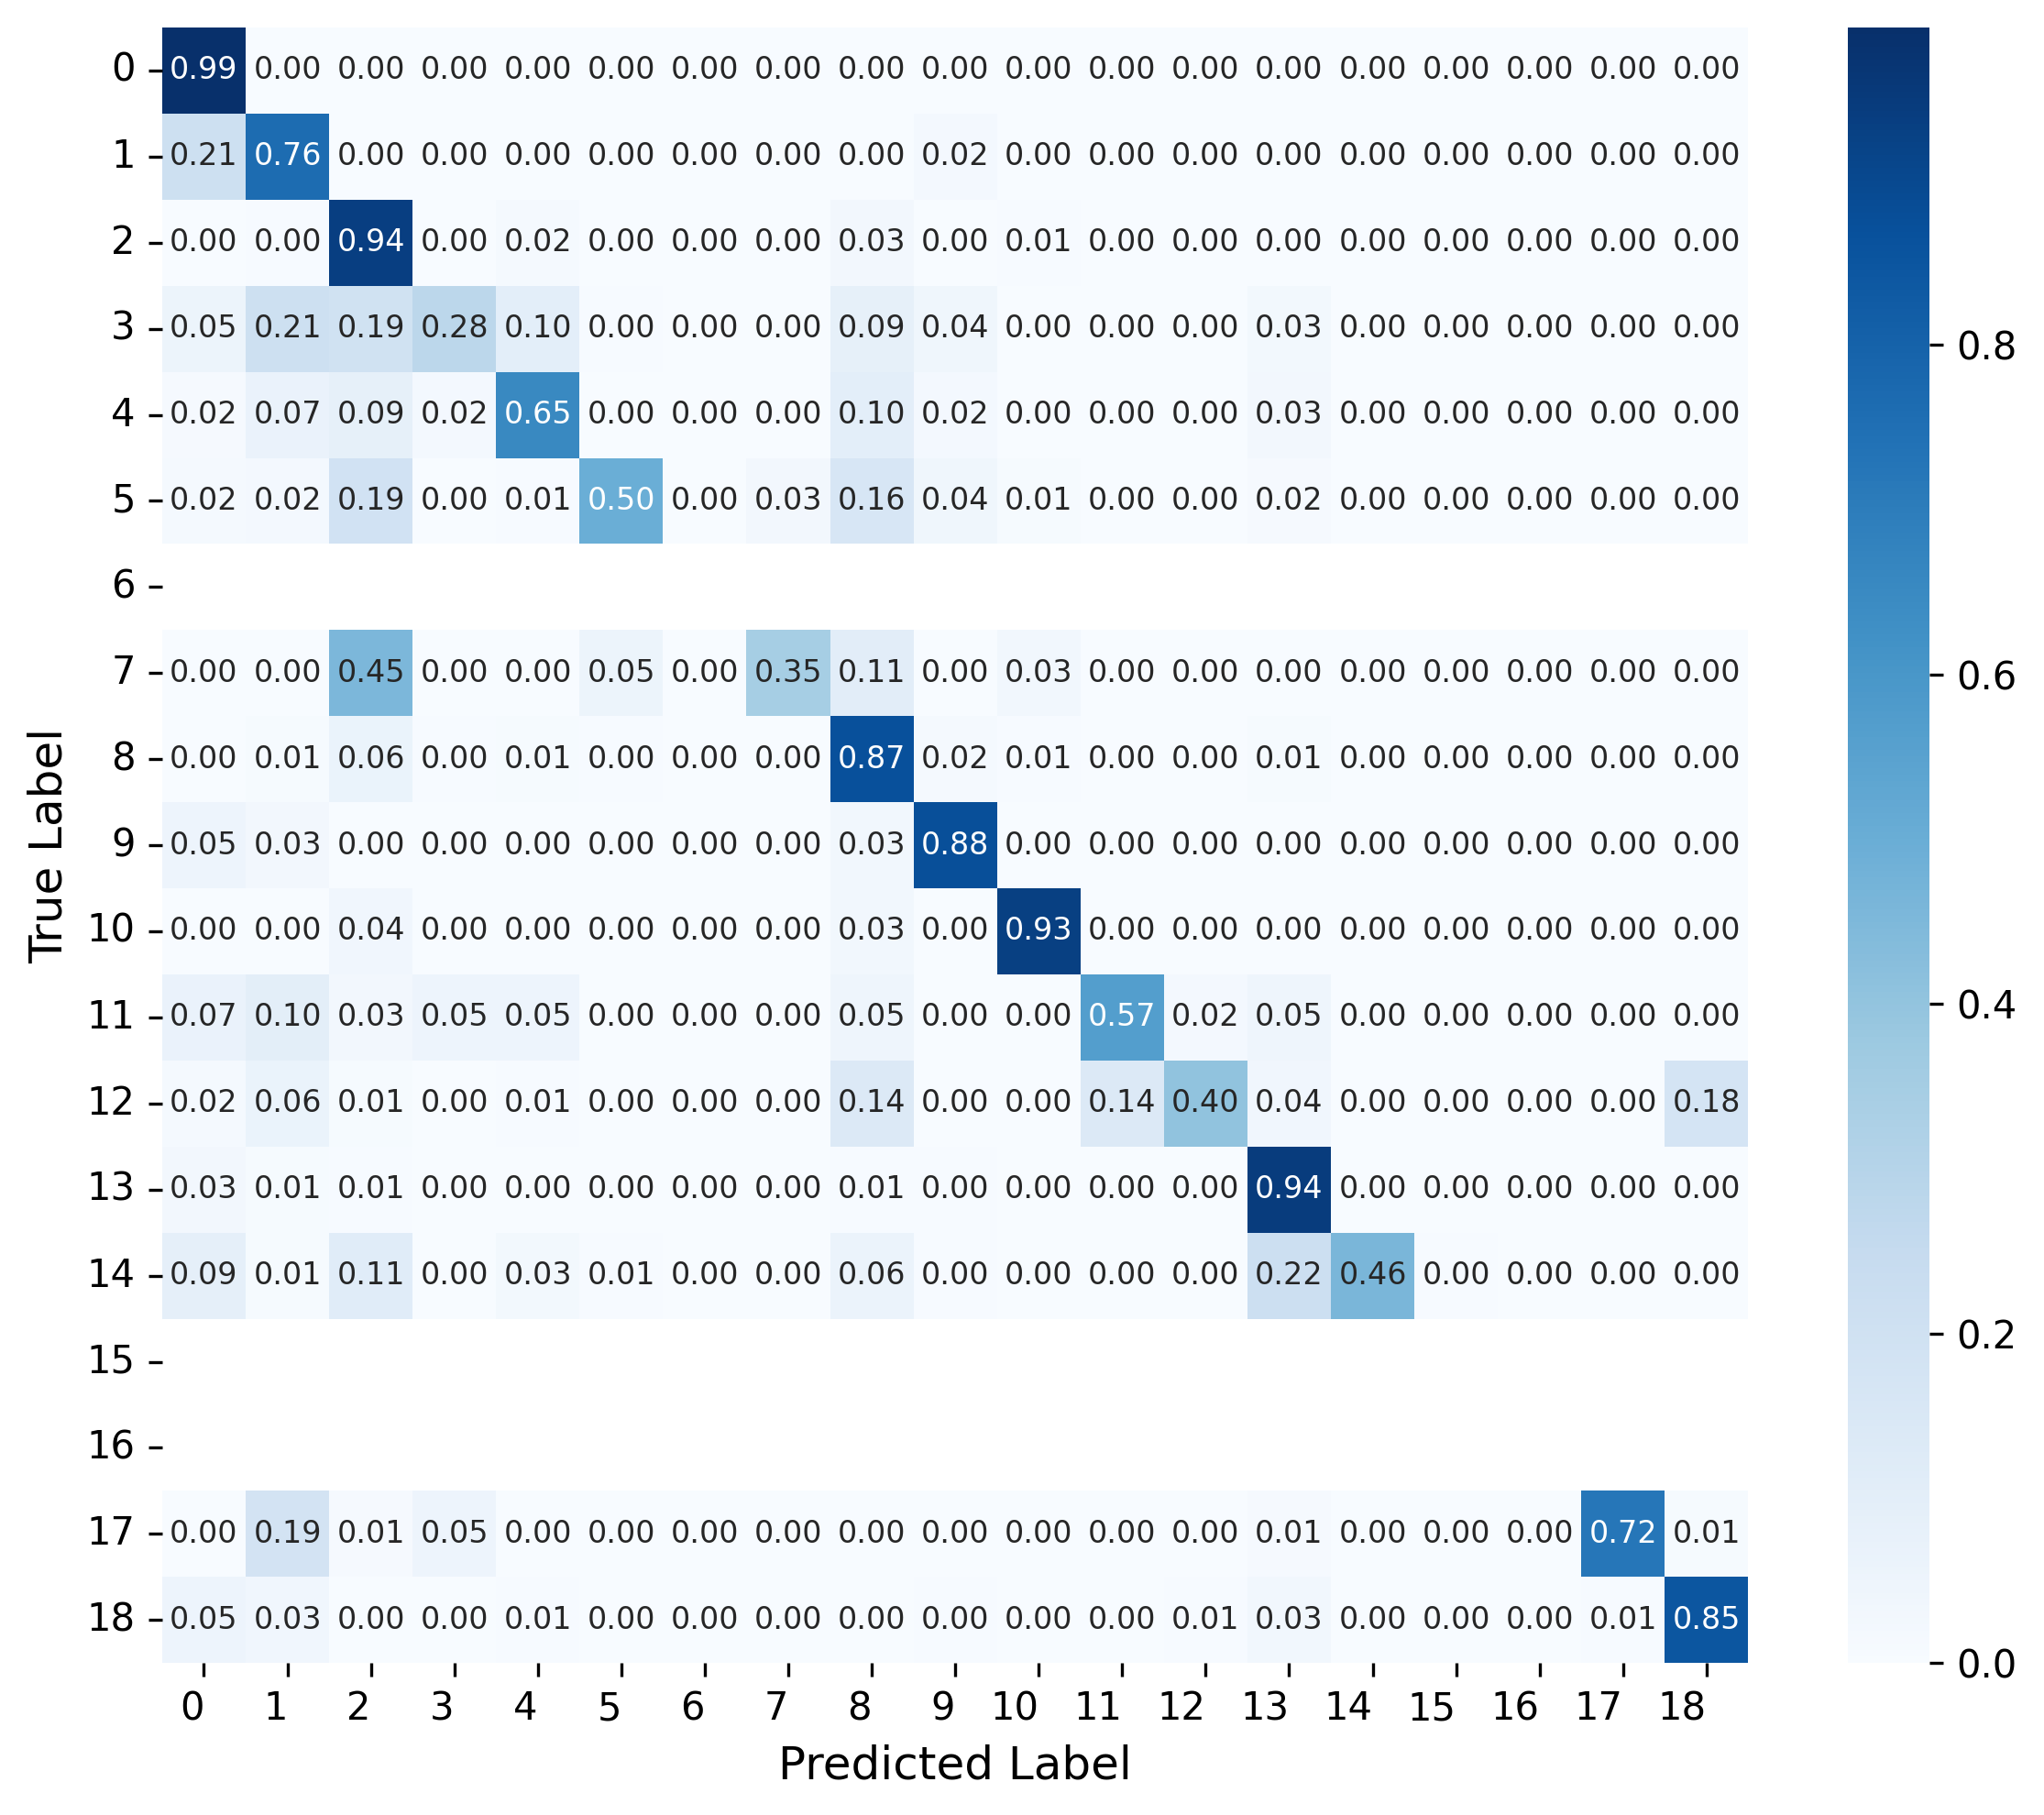

In [12]:
for dataset_name, json_file in datasets:
    print(f"\nAnalyzing {dataset_name.upper()} dataset:")
    
    # Load data
    val_loader, val_image_paths, val_ground_truth_paths = load_data(json_file, dataset_name, num_test=2000)
    baseline_results = validate(baseline_model, val_loader, device, metrics)
    fig = metrics.plot_confusion_matrix()
    display(fig)
    fig.savefig(f'confusion_matrix_baseline_{dataset_name}.png', bbox_inches='tight', dpi=300)
    plt.close(fig)
    


    finetuned_results = validate(finetuned_model, val_loader, device, metrics)
    fig = metrics.plot_confusion_matrix()
    display(fig)
    fig.savefig(f'confusion_matrix_Finetuned_{dataset_name}.png', bbox_inches='tight', dpi=300)
    plt.close(fig)
    
    # finetuned_additional = calculate_additional_metrics(metrics, num_classes=19)
    
    # # Print metrics
    # print("\nFine-tuned Metrics:")
    # for k, v in {**finetuned_results, **finetuned_additional}.items():
    #     if k != 'Confusion Matrix':
    #         print(f"{k}: {v}")
